# DeepFM

## 0. Imports

In [1]:
# Basic Data Analysis Tools
import numpy as np
import pandas as pd
from os.path import exists
import itertools

# Keras imports for deepFM, 1st & 2nd order FM: all of which can be implemented as neural networks
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

# TODO: shapley for feature importance evaluation

In [2]:
def transaction_preprocess(transactions, train_bounds, test_bounds, time_period = 125):
    """
    args:
        transactions: pd.DataFrame -> the transaction_history.csv provided by Siemens
        train_bounds, test_bounds: (lower: int, upper: int) -> bounds for splitting dataset into train and test based on "day" feature
        time_period: map day feature into month, years, etc. (default 125 days = 4 months)
    returns:
        transactions: pd.DataFrame -> processed dataframe with encoded categories and mapped days
        train_rnd_sample: pd.DataFrame -> all positive samples within train as well as an equal number of randomly sampled negative samples
        test_rnd_sample: pd.DataFrame -> 
    """
    transactions = transactions.copy() 
    
    # encode categorical variables
    transactions["customer"] = transactions["customer"].astype('category').cat.codes + 1
    
    # FOR TESTING PURPOSES: I dont have much RAM :)
    # transactions = transactions[(transactions["customer"] > 100) & (transactions["customer"] < 200)]
    # transactions["customer"] = transactions["customer"].astype('category').cat.codes + 1
    
    transactions["day"] = transactions["day"] // time_period # map days to weeks, months, years
    transactions["prod"] = transactions["prod"].astype('category').cat.codes 
    transactions["state"] = transactions["state"].astype('category').cat.codes + 1
    transactions["ind_code"] = transactions["ind_code"].astype('category').cat.codes + 1
    transactions["ind_seg_code"] = transactions["ind_seg_code"].astype('category').cat.codes + 1
    
    # set labels to 1 - all products present were bought
    transactions["label"] = 1
    
    # create product customer list
    transactions["prod_customer"] = list(zip(transactions["customer"], transactions["prod"]))
    # drop rows with missing values
    transaction = transactions.dropna()
    
    # create train & test set
    train = transactions[(transaction.day >= train_bounds[0] // time_period) & (transactions.day < train_bounds[1] // time_period)]
    test = transactions[(transaction.day >= test_bounds[0] // time_period) & (transactions.day < test_bounds[1] // time_period)]
    
    # get unique customer and product lists
    customers = transactions["customer"].unique()
    products = train["prod"].unique() # transactions["prod"].unique() # use products only from train to make sure
    
    # set of day-customer-bought product for negative sampling
    hit_combo = set(list(zip(transactions["day"], transactions["customer"], transactions["prod"])))
    
    # get days and customers
    test_days = test["day"].unique()
    hit_combo_2 = list(zip(test["day"], test["customer"], test["prod"]))
    
    prod_list = set(products) 
    test_customer_prod_day = set([tuple(r) for r in test[["day", "customer", "prod"]].to_numpy()]) # Set of positive test_days x customer x prod
    all_test_customer_prod_day = set([x for x in itertools.product(test_days, customers, products)]) # Set of all test_days x customer x prod
    neg_test_customer_prod_day = all_test_customer_prod_day - test_customer_prod_day # Set of negative test_days x customer x prod
    
    # Create test dataset
    final_neg_sampl = test[["customer", "domestic", "state",
                            "ind_code", "ind_seg_code"]].drop_duplicates() # customer info - customer_id unique identifier of customer
    final_neg_sampl = final_neg_sampl.merge(pd.DataFrame(neg_test_customer_prod_day, columns=["day", "customer", "prod"]), how="inner", on="customer") # cartezian product of product, customer, day and customer info
    final_neg_sampl["label"] = 0 # set all products as unbought (non-sampled)
    test["label"] = 1 # set all products present in test as positive
    final_neg_sampl = final_neg_sampl.append(test.drop(["new_orders", "prod_customer"],axis=1)) # join positive and negative
    final_neg_sampl = final_neg_sampl.drop_duplicates()

    
    # specify train sample size (c)
    SAMPLE_SIZE = int(np.ceil(1.0 * len(train))) # Set negative train size
    train_days = train["day"].unique()
    
    # Bootstrap negative sample train set (only samples from train set were used) - in case no bootstraping is desired change replace -> False
    # Removes potential outliers which have for example bought only one item or that are highly unlikely to buy an item
    train_rnd_sample = np.array([np.random.choice(train_days, size=SAMPLE_SIZE),\
                                              np.random.choice(customers, size=SAMPLE_SIZE),\
                                              np.random.choice(products, size=SAMPLE_SIZE)]).T
    
    # remove samples that were actually bought (are in hit_combo)
    not_faulty = [tuple(train_rnd_sample[row,:]) not in hit_combo for row in range(train_rnd_sample.shape[0])]
    train_rnd_sample = train_rnd_sample[not_faulty]
    
    # Drop duplicated rows
    train_rnd_sample = pd.DataFrame(train_rnd_sample,
                                   columns=["day", "customer", "prod"]).drop_duplicates()
    
    # Add customer info - uniquely defined by customer_id
    train_rnd_sample = train_rnd_sample.merge(transactions[["customer", "domestic", "state", "ind_code",
                                                            "ind_seg_code"]].drop_duplicates(),
                                              on="customer")
    train_rnd_sample["label"] = 0 # Set negative labels
    
    # Merge positive and negative train samples
    train_rnd_sample = train_rnd_sample.append(train[["day", "customer", "prod", "domestic", "state", "ind_code",
                                                            "ind_seg_code", "label"]], ignore_index=True)
    
    return transactions, train_rnd_sample.sample(frac=1).reset_index(drop=True), final_neg_sampl, products, customers


In [3]:
transactions = pd.read_csv("dataset/transaction_history.csv") # load dataset
transformations = [] # includes train, test folds for CV

for i in range(1):
    print(f"Iteration {i}", end="\r")
    transformed, train, test, products, customers = transaction_preprocess(transactions, (i*125, (i+4)*125), ((i+4)*125, (i+5)*125)) 
    print(test.drop_duplicates().label.sum())
    transformations.append((train, test))
train, test = transformations[0]

675ration 0


C:\Users\david\AppData\Local\Temp\ipykernel_30588\2877272566.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["label"] = 1 # set all products present in test as positive
C:\Users\david\AppData\Local\Temp\ipykernel_30588\2877272566.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_neg_sampl = final_neg_sampl.append(test.drop(["new_orders", "prod_customer"],axis=1)) # join positive and negative
C:\Users\david\AppData\Local\Temp\ipykernel_30588\2877272566.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_rnd_sample = train_rnd_sample.append(train[[

In [4]:
test.label.sum()

675

## 1. Models

### 1.1 Model parts

In [5]:
def define_input_layers(df):
    """
    Defines input layers for all ML models used in this notebook.
    
    args:
        transactions: pd.DataFrame -> the transformed transaction history, with encoded categories
    returns:
        inputs: keras.inputs -> 'day', 'customer', 'prod', 'state', 'ind_code', 'ind_seg_code', 'domestic'
    """
    day_input = Input((1,), name = 'day')
    num_inputs = [day_input] # continuous numeric inputs
    cat_input = [Input((1,), name= col) for col in ['customer', 'prod', 'state', 'ind_code',
       'ind_seg_code', 'domestic']] # discrete categorical inputs
    cat_sl_inputs = [cat_input] 

    inputs = num_inputs + cat_sl_inputs # join inputs
    
    return inputs

inputs = define_input_layers(transformed)

In [6]:
def Tensor_Mean_Pooling(name = 'mean_pooling', keepdims = False):
    return Lambda(lambda x: K.mean(x, axis = 1, keepdims=keepdims), name = name)

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'day')>, [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'customer')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'prod')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'state')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ind_code')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ind_seg_code')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'domestic')>]]


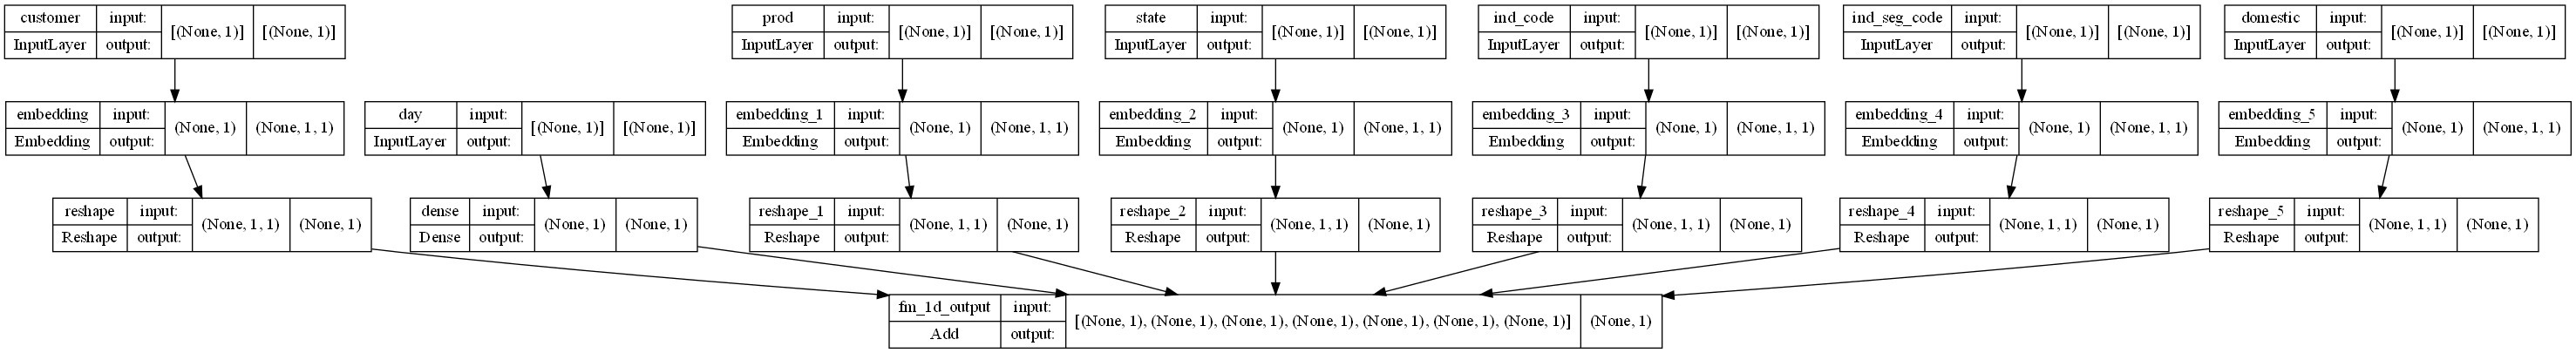

In [7]:
def fm_1d(inputs):
    """
    1st order FM output = sum a_i * f_i, linear combination of features
    
    args:
        transactions: pd.DataFrame -> the transformed transaction history, with encoded categories
    returns:
        inputs: keras.inputs -> 'day', 'customer', 'prod', 'state', 'ind_code', 'ind_seg_code', 'domestic'
    """
    num_inputs, cat_inputs = inputs 
    
    # all tensors are reshaped to (None, 1)
    num_dense_1d  = [Dense(1)(num_inputs)]
    
    cat_sl_embed_1d = [Embedding(transformed[inpt.name].nunique() + 1, 1)(inpt) for inpt in cat_inputs]
    cat_sl_embed_1d = [Reshape((1,))(i) for i in cat_sl_embed_1d]
    
    # add all tensors
    y_fm_1d = Add(name = 'fm_1d_output')(num_dense_1d + cat_sl_embed_1d)
    return y_fm_1d

y_1d = fm_1d(inputs)
fm_model_1d = Model(inputs, y_1d)
print(fm_model_1d.input)
plot_model(fm_model_1d, show_shapes=True, show_layer_names=True)

(None, 7, 10)
[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'day')>, [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'customer')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'prod')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'state')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ind_code')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ind_seg_code')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'domestic')>]]


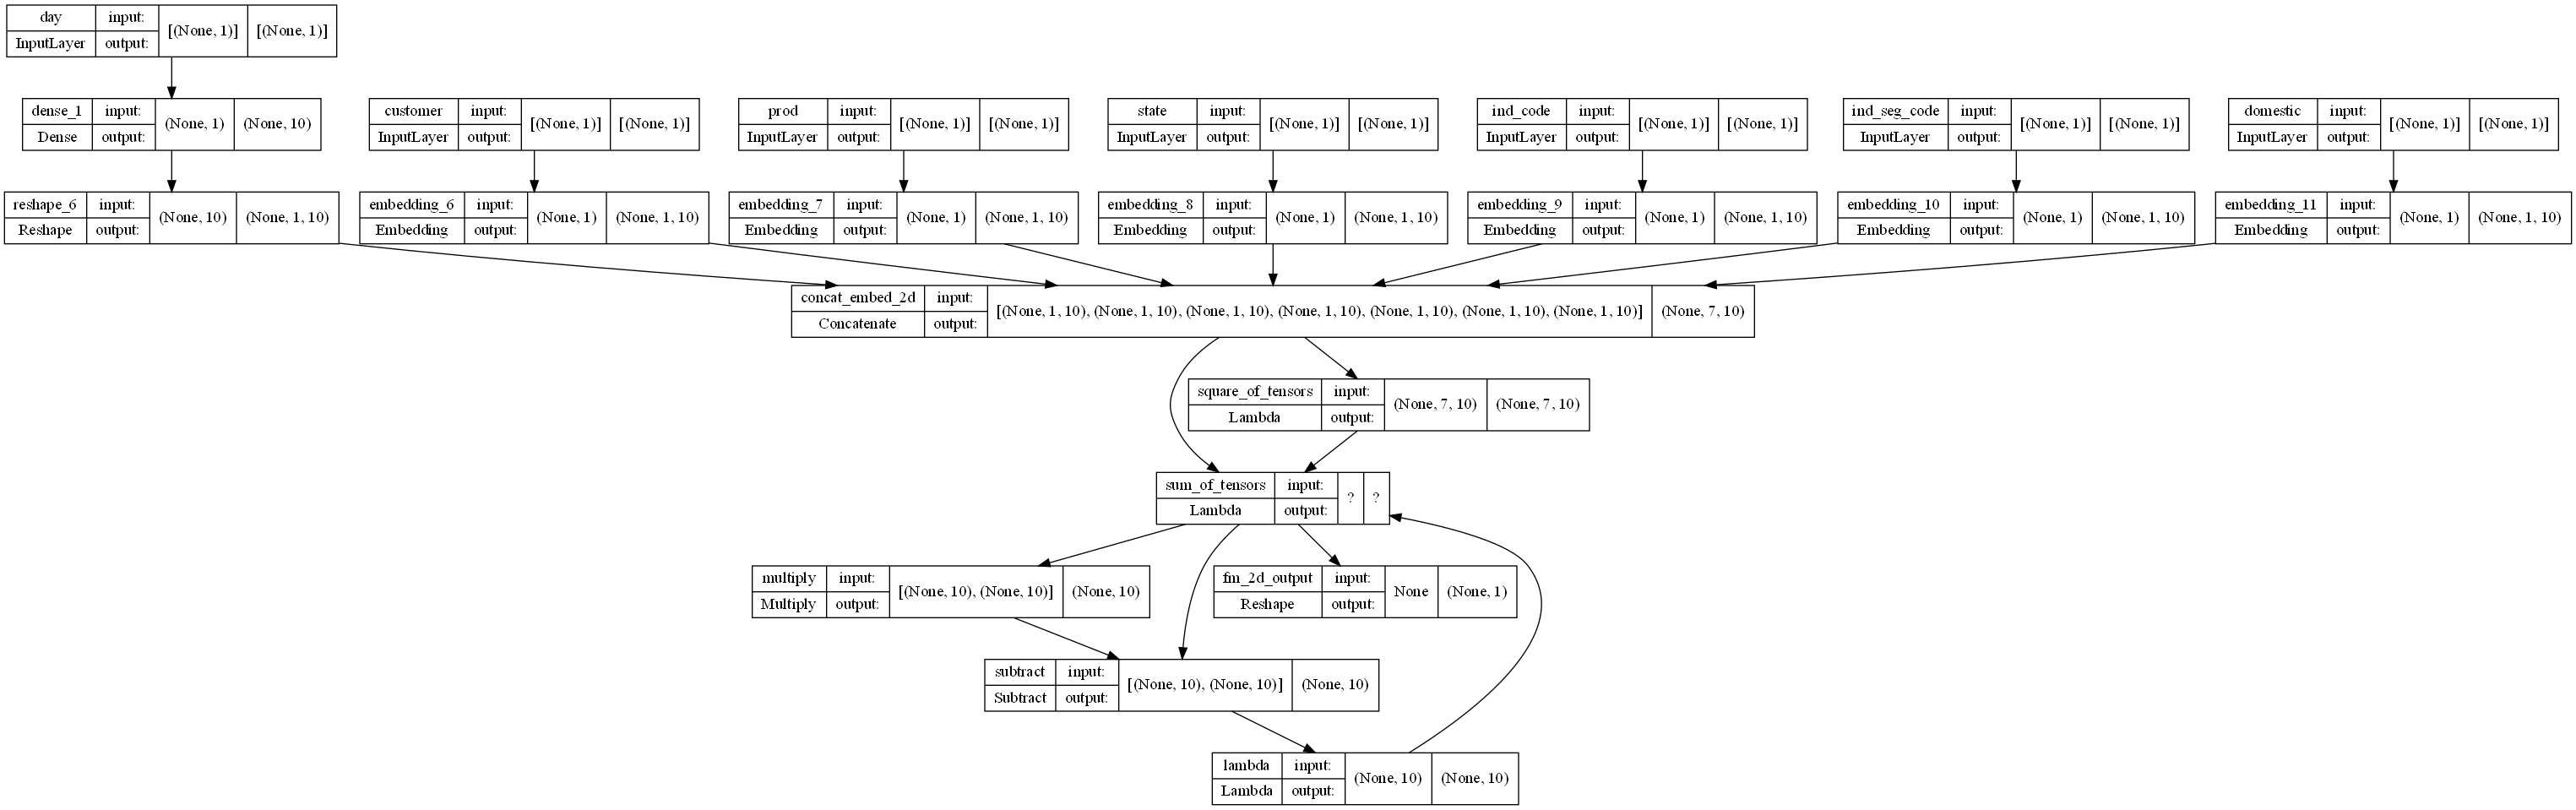

In [8]:
def fm_2d(inputs, k):
    num_inputs, cat_inputs = inputs
    
    num_dense_2d = [Dense(k)(num_inputs)]
    num_dense_2d = [Reshape((1,k))(i) for i in num_dense_2d]
    
    cat_sl_embed_2d = [Embedding(transformed[inpt.name].nunique() + 1, k)(inpt) for inpt in cat_inputs]
    
    embed_2d = Concatenate(axis=1, name = 'concat_embed_2d')(num_dense_2d + cat_sl_embed_2d)
    
    tensor_sum = Lambda(lambda x: K.sum(x, axis = 1), name = 'sum_of_tensors')
    tensor_square = Lambda(lambda x: K.square(x), name = 'square_of_tensors')

    sum_of_embed = tensor_sum(embed_2d)
    square_of_embed = tensor_square(embed_2d)
    
    square_of_sum = Multiply()([sum_of_embed, sum_of_embed])
    sum_of_square = tensor_sum(square_of_embed)
    
    sub = Subtract()([square_of_sum, sum_of_square])
    sub = Lambda(lambda x: x*0.5)(sub)
    y_fm_2d = Reshape((1,), name = 'fm_2d_output')(tensor_sum(sub))
    
    return y_fm_2d, embed_2d
    
y_2d, embed_2d = fm_2d(inputs, 10)
print(embed_2d.shape)
fm_model_2d = Model(inputs, y_2d)
print(fm_model_2d.input)
plot_model(fm_model_2d, show_shapes=True, show_layer_names=True)

(None, 7, 10)
[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'deep_output')>]


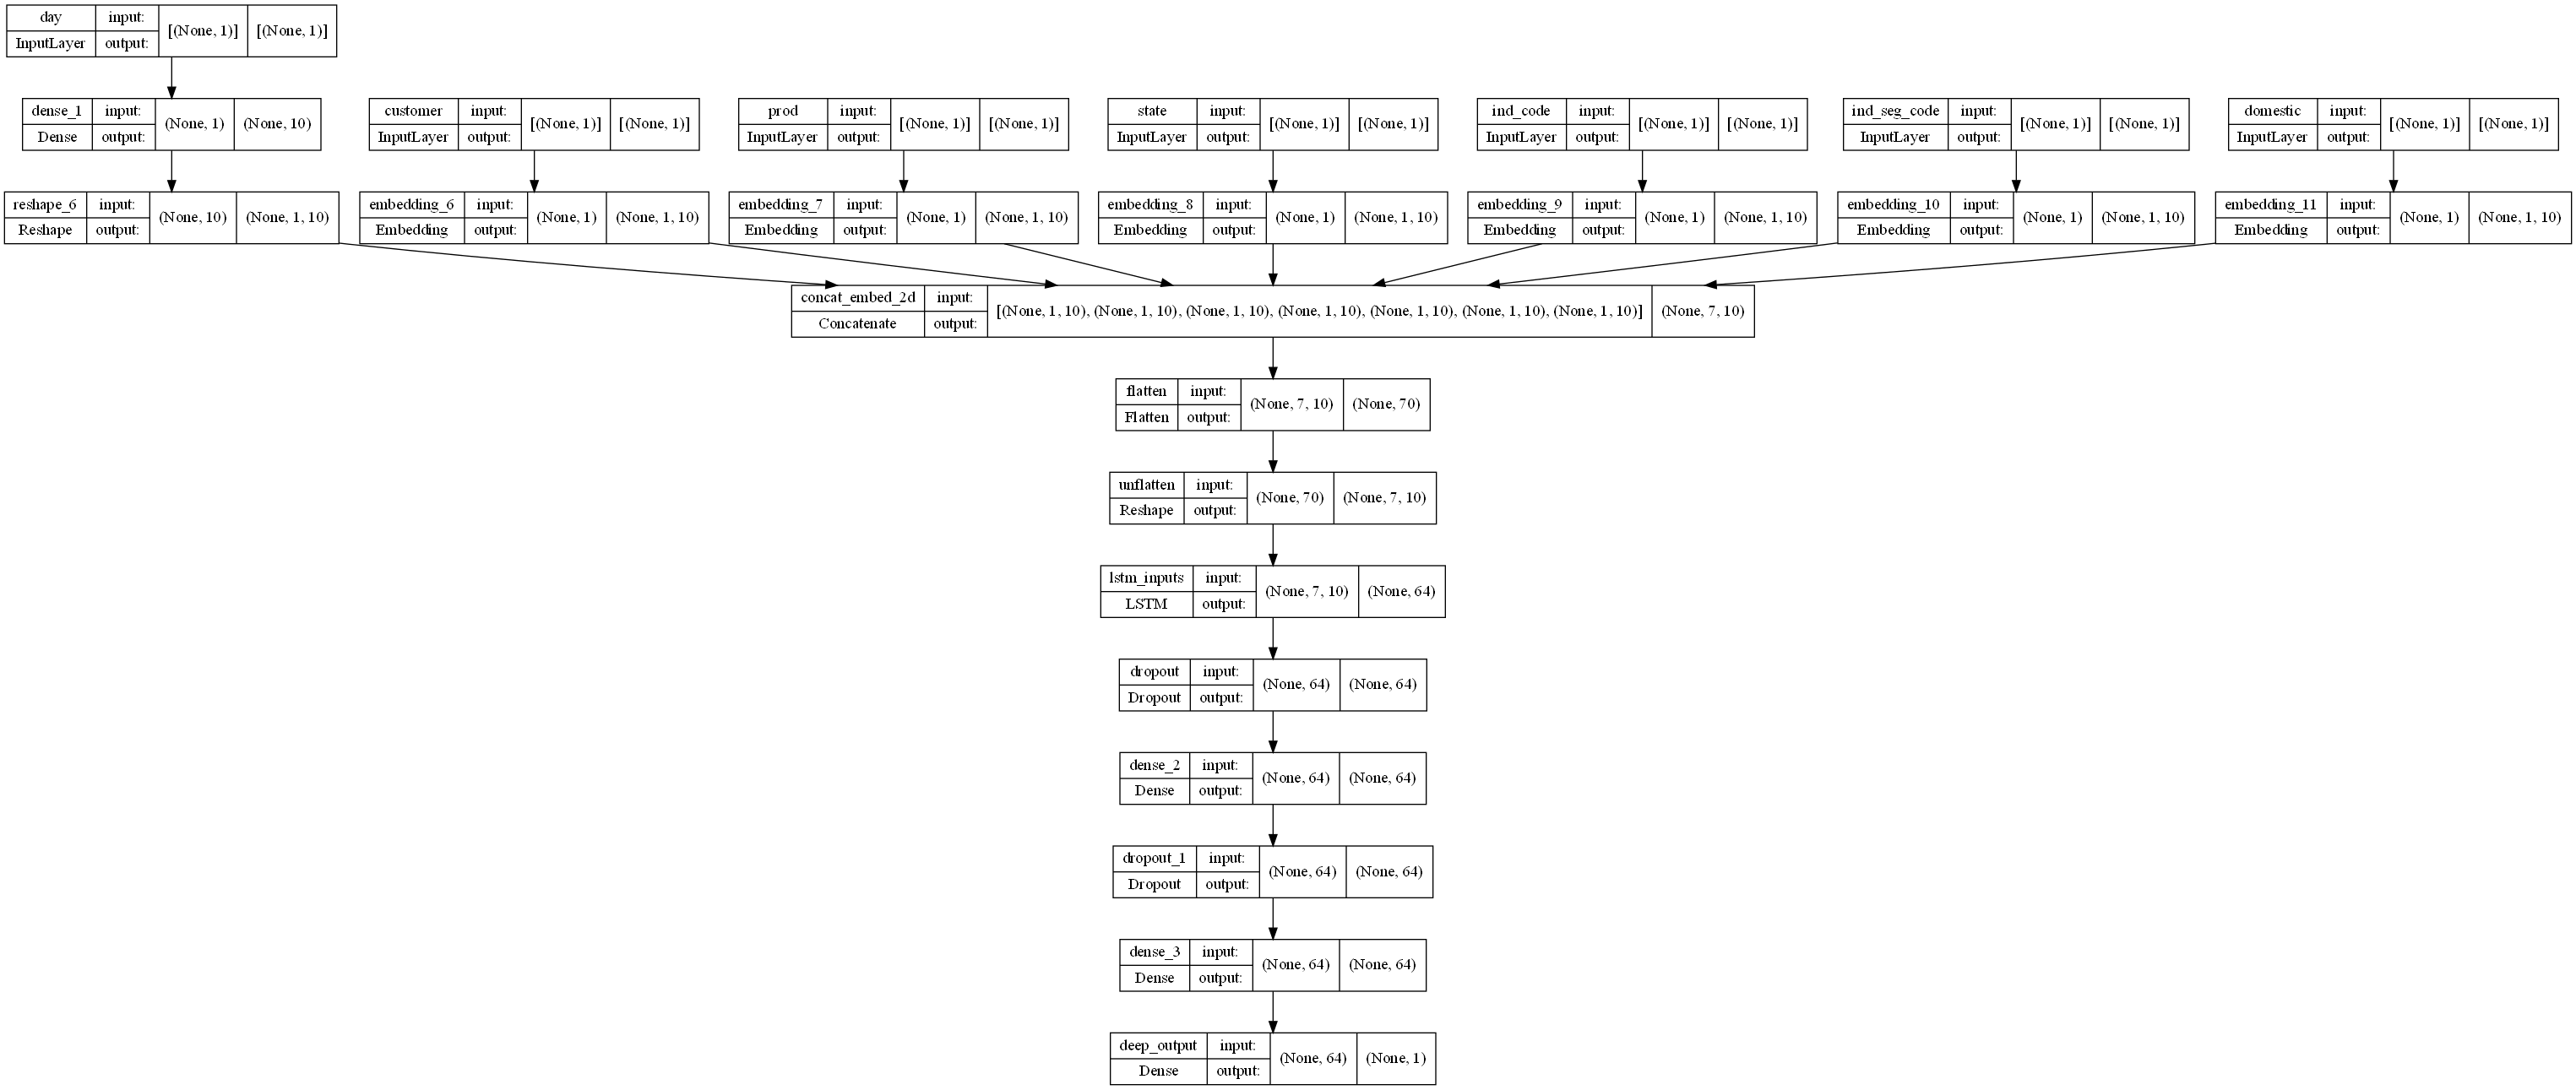

In [11]:
def lstm_part(embed_2d, lstm_dim, dnn_dim, dnn_dr):
    num_inputs, cat_inputs = inputs
    
    # flat embed layers from 3D to 2D tensors
    print(embed_2d.shape)
    # flatten and unflatten (needed for concetanation)
    # k = 20
    # num_dense_1d = [Dense(k)(num_inputs)]
    # num_dense_2d = [Reshape((1,k))(i) for i in num_dense_2d]
    y_dnn = Flatten(name = 'flatten')(embed_2d)
    y_dnn = Reshape(embed_2d.shape[1:], name = "unflatten")(y_dnn)
    
    l1, l2 = 1e-4, 1e-4
    
    if len(lstm_dim) > 0:
        y_dnn = LSTM(lstm_dim[0], activation='tanh', return_sequences=False, name="lstm_inputs",
                      kernel_regularizer=regularizers.L1(l1),
                      activity_regularizer=regularizers.L2(l2))(y_dnn) # Flatten(name = 'flat_embed_2d')(embed_2d)
    
    #print("Got to here!")
    for h in lstm_dim[1:-1]:
        print("Got to here!")
        y_dnn = LSTM(h, return_sequences=True, activation='tanh',
                      kernel_regularizer=regularizers.L1(l1),
                      activity_regularizer=regularizers.L2(l2))(y_dnn)
        y_dnn = Dropout(dnn_dr)(y_dnn)
    
    if len(lstm_dim) > 1:
        y_dnn = LSTM(lstm_dim[-1], return_sequences=False, activation='tanh', name="lstm_outputs",
                      kernel_regularizer=regularizers.L1(l1),
                      activity_regularizer=regularizers.L2(l2))(y_dnn)
        y_dnn = Dropout(dnn_dr)(y_dnn)
    
    for h in dnn_dim:
        y_dnn = Dropout(dnn_dr)(y_dnn)
        y_dnn = Dense(h, activation='relu',
                      kernel_regularizer=regularizers.L1(l1),
                      activity_regularizer=regularizers.L2(l2))(y_dnn)
    y_dnn = Dense(1, activation='relu', name = 'deep_output')(y_dnn)
    
    return y_dnn

y_dnn = lstm_part(embed_2d, [64], [64, 64], 0.5)
fm_model_dnn = Model(inputs, y_dnn)
print(fm_model_dnn.outputs)
plot_model(fm_model_dnn, show_shapes=True, show_layer_names=True)

### 1.2 Models

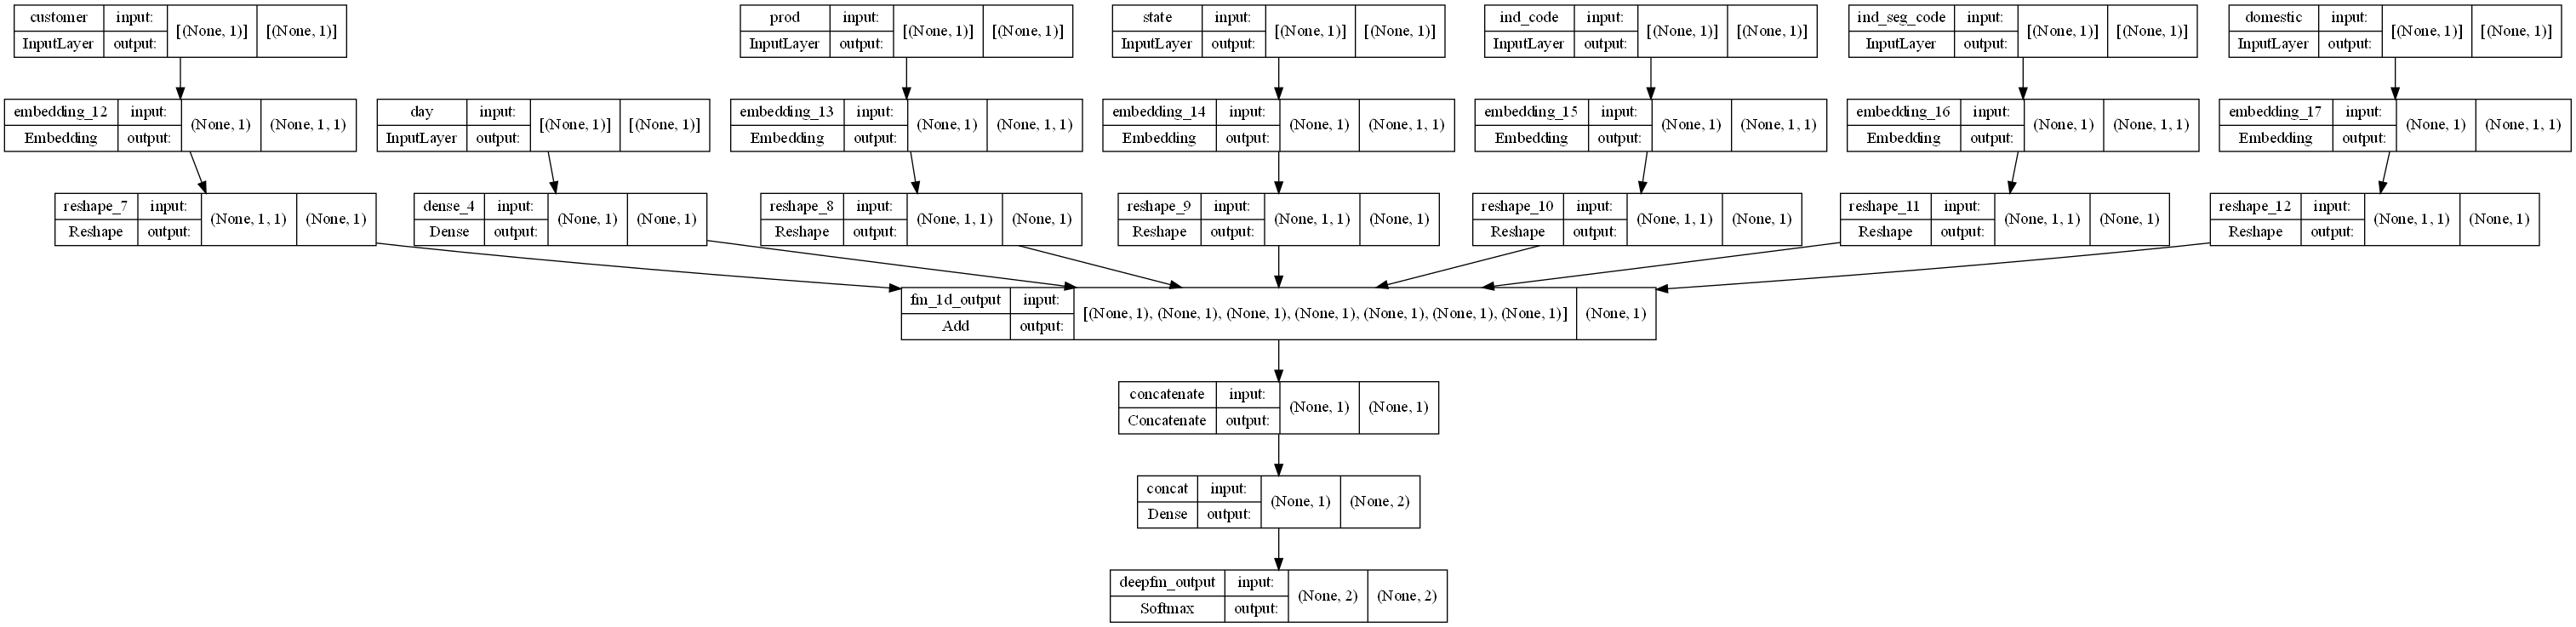

In [12]:
def mf_model():
    inputs = define_input_layers(transformed)
    y_fm_1d = fm_1d(inputs)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d])
    y = Dense(2, name = "concat")(y)
    y = Softmax(name = 'deepfm_output')(y)
    mf_model = Model(inputs, y)
    return mf_model

MF = mf_model()
plot_model(MF, show_shapes=True, show_layer_names=True)

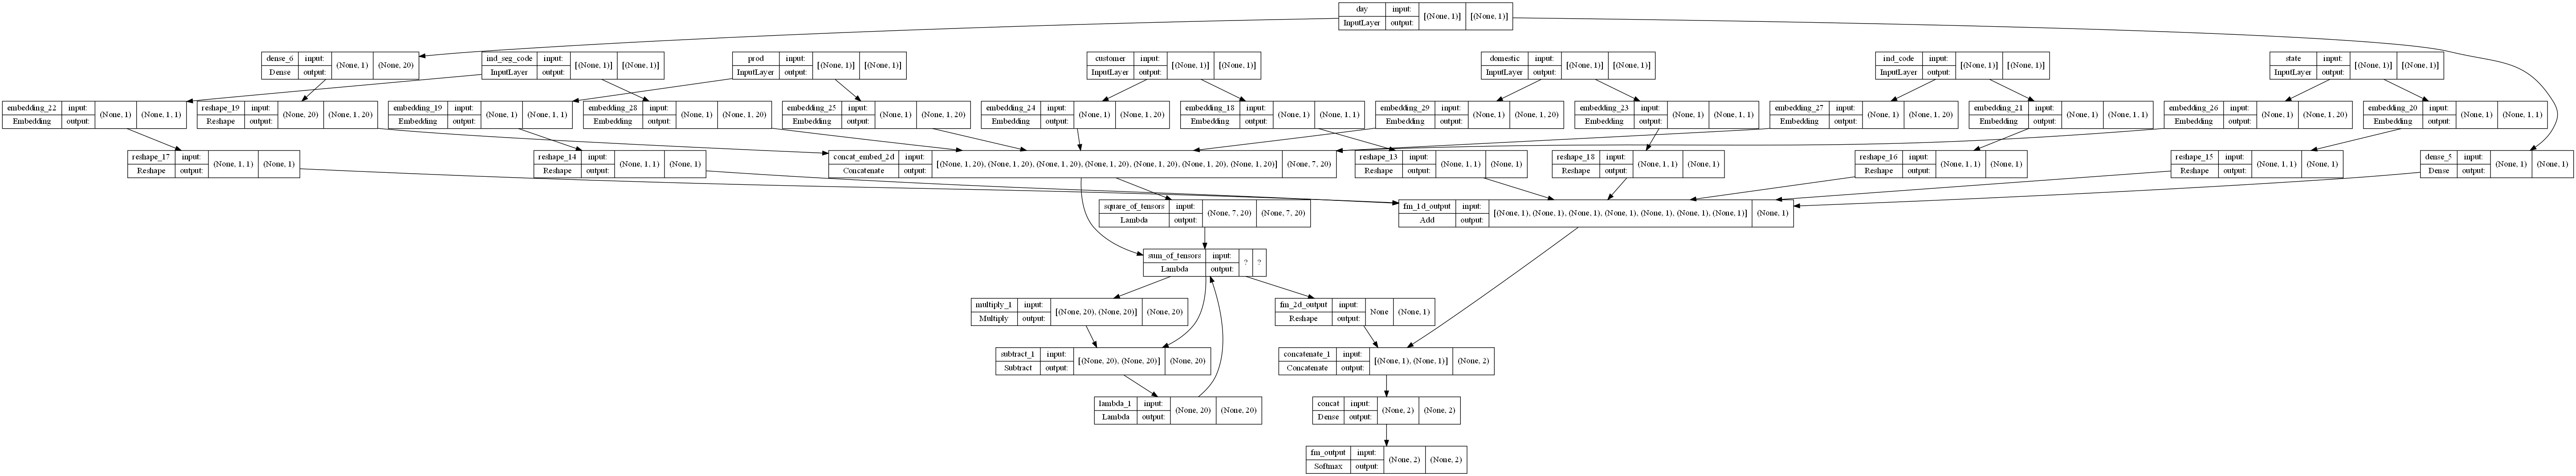

In [13]:
FM_params = {
    'k':20
}

def fm_model(k):
    inputs = define_input_layers(transformed)
    
    y_fm_1d = fm_1d(inputs)
    y_fm_2d, embed_2d = fm_2d(inputs, k)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_fm_2d])
    y = Dense(2, name = "concat")(y)
    y = Softmax(name = 'fm_output')(y)
    FM_model = Model(inputs, y)
    
    return FM_model, embed_2d
FM, _ = fm_model(**FM_params)
plot_model(FM, show_shapes=True, show_layer_names=True)

(None, 7, 10)


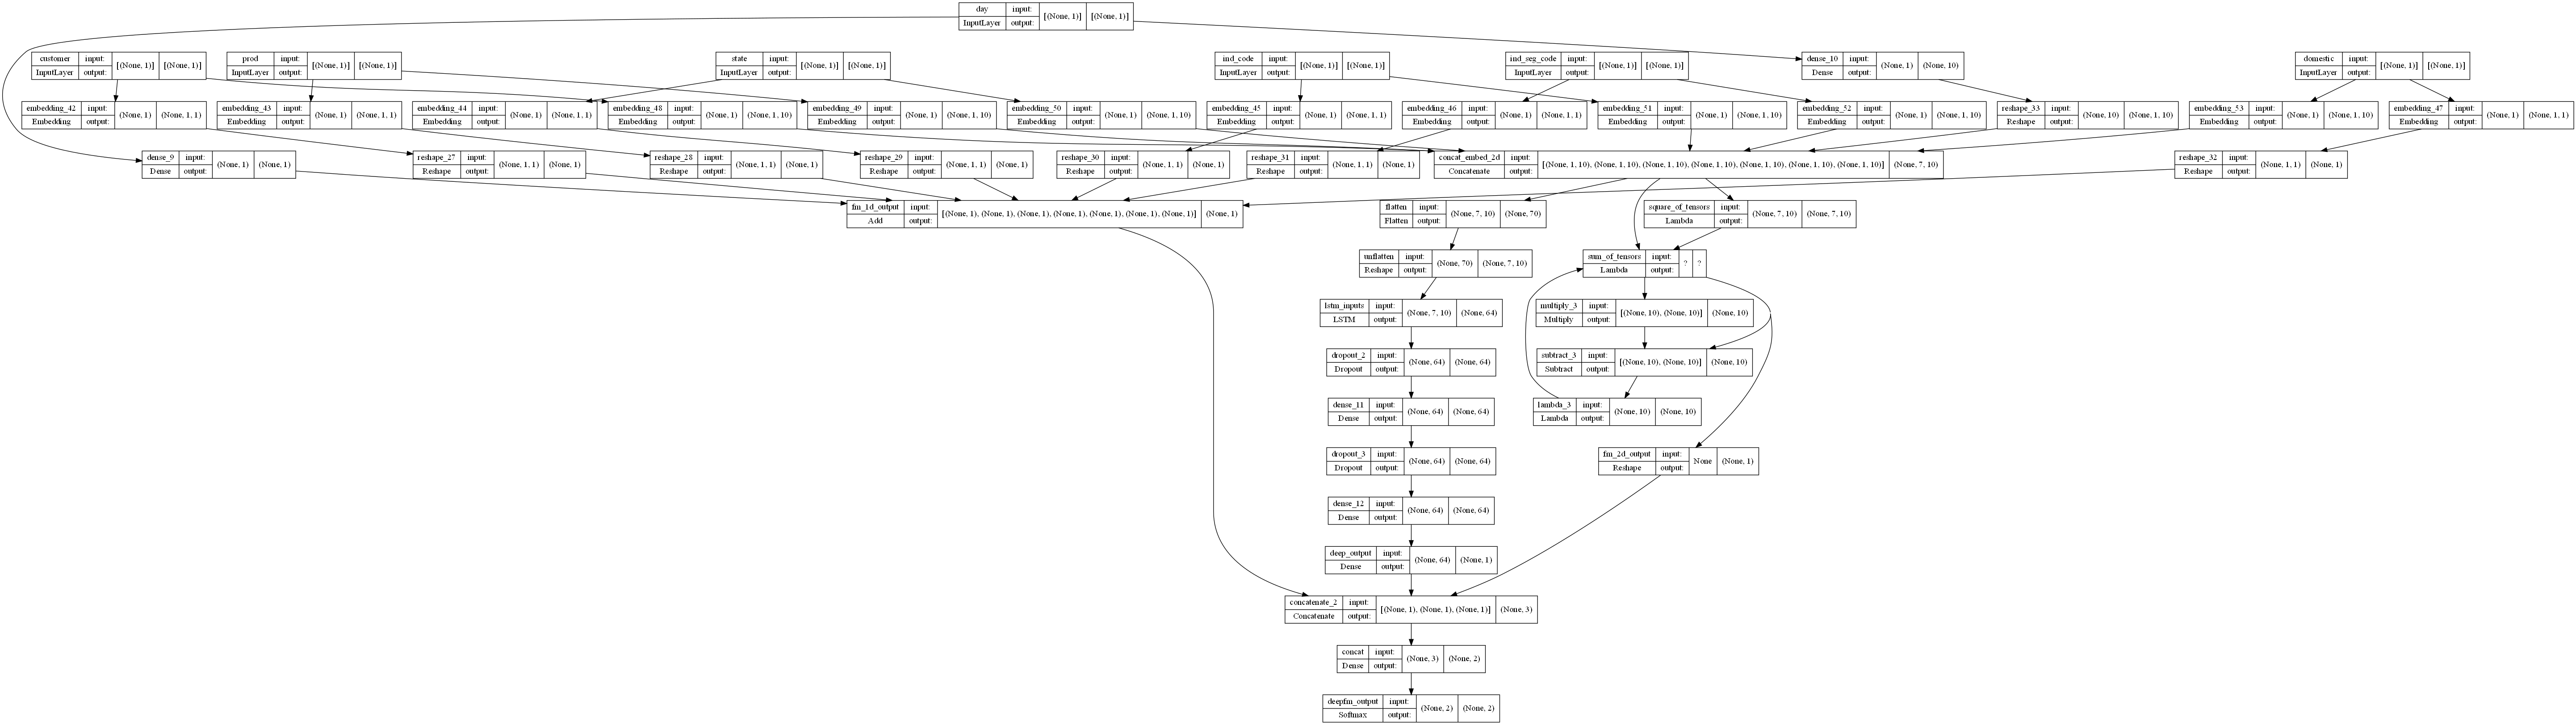

In [15]:
deepFM_params = {
    'k':10,
    'lstm_dim': [64],
    'dnn_dim':[64, 64],
    'dnn_dr': 0.2
}

def deep_fm_model(k, lstm_dim, dnn_dim, dnn_dr):
    
    inputs = define_input_layers(transformed)
    
    y_fm_1d = fm_1d(inputs)
    y_fm_2d, embed_2d = fm_2d(inputs, k)
    y_dnn = lstm_part(embed_2d, lstm_dim, dnn_dim, dnn_dr)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_fm_2d, y_dnn])
    y = Dense(2, name = "concat")(y)
    y = Softmax(name = 'deepfm_output')(y)
    deep_fm_model = Model(inputs, y)
    
    return deep_fm_model
deepFM = deep_fm_model(**deepFM_params)
plot_model(deepFM, show_shapes=True, show_layer_names=True)

## 2. Training

In [16]:
def df2xy(df, model):
    x = [df[inp.name].values for inp in model.inputs]
    y = df.label.values
    return x,np.asarray(y).astype('float32')

In [17]:
mf_model_arr = []

for i, transaction_tuple in zip(range(len(transformations)), transformations):
    train, test = transaction_tuple
    fm_model_1d = mf_model()
    train_x, train_y = df2xy(train, fm_model_1d)
    train_y = pd.get_dummies(pd.Series(train_y)).to_numpy()
    fm_model_1d.compile(loss = 'binary_crossentropy', optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    model_ckp = ModelCheckpoint(filepath=f'./models/1d_{i}.h5', 
                                    monitor='val_loss',
                                    save_weights_only=True, 
                                    save_best_only=True)
    callbacks = [early_stop, model_ckp]
    if not exists(f'./models/1d_{i}.h5'):
        print(train)
        print(train_x)
        train_history = fm_model_1d.fit(train_x, train_y, 
                                              epochs=100, batch_size=256, 
                                              validation_split=0.1, 
                                              callbacks = callbacks)
    mf_model_arr.append(fm_model_1d)
fm_model_1d.load_weights(f"./models/1d_0.h5")

ValueError: Cannot assign value to variable ' embedding_55/embeddings:0': Shape mismatch.The variable shape (1486, 1), and the assigned value shape (2252, 1) are incompatible.

In [ ]:
fm_model_arr = []

for i, transaction_tuple in zip(range(len(transformations)), transformations):
    train, test = transaction_tuple
    fm_model_2d, _ = fm_model(**FM_params)
    train_x, train_y = df2xy(train, fm_model_2d)
    train_y = pd.get_dummies(pd.Series(train_y)).to_numpy()
    fm_model_2d.compile(loss = 'binary_crossentropy', optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    model_ckp = ModelCheckpoint(filepath=f'./models/2d_{i}.h5', 
                                    monitor='val_loss',
                                    save_weights_only=True, 
                                    save_best_only=True)
    callbacks = [early_stop, model_ckp]
    if not exists(f'./models/2d_{i}.h5'):
        train_history = fm_model_2d.fit(train_x, train_y,
                                              epochs=100, batch_size=256, 
                                              validation_split=0.1, 
                                              callbacks = callbacks)
    fm_model_arr.append(fm_model_1d)
fm_model_2d.load_weights('./models/2d_0.h5')

In [18]:
deepfm_model_arr = []

for i, transaction_tuple in zip(range(len(transformations)), transformations):
    train, test = transaction_tuple
    deepfm_model = deep_fm_model(**deepFM_params)
    train_x, train_y = df2xy(train, deepfm_model)
    train_y = pd.get_dummies(pd.Series(train_y)).to_numpy()
    deepfm_model.compile(loss = 'binary_crossentropy', optimizer=keras.optimizers.Adam(lr=5e-4))
    early_stop = EarlyStopping(monitor='val_loss', patience=20)
    model_ckp = ModelCheckpoint(filepath=f'./models/lstmfm_{i}.h5', 
                                    monitor='val_loss',
                                    save_weights_only=True, 
                                    save_best_only=True)
    callbacks = [early_stop, model_ckp]
    if not exists(f'./models/lstmfm_{i}.h5'):
        train_history = deepfm_model.fit(train_x, train_y, 
                                              epochs=100, batch_size=256, 
                                              validation_split=0.1, 
                                              callbacks = callbacks)
    deepfm_model_arr.append(deepfm_model)
deepfm_model.load_weights(f'./models/lstmfm_0.h5')

(None, 7, 10)


C:\Users\david\anaconda3\envs\nigga\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
28/28 [==============================] - 7s 53ms/step - loss: 1.0000 - val_loss: 0.9348
Epoch 2/100
28/28 [==============================] - 1s 50ms/step - loss: 0.9005 - val_loss: 0.7807
Epoch 3/100
28/28 [==============================] - 1s 54ms/step - loss: 0.7558 - val_loss: 0.7118
Epoch 4/100
28/28 [==============================] - 1s 34ms/step - loss: 0.6869 - val_loss: 0.6453
Epoch 5/100
28/28 [==============================] - 0s 16ms/step - loss: 0.6177 - val_loss: 0.5736
Epoch 6/100
28/28 [==============================] - 0s 13ms/step - loss: 0.5464 - val_loss: 0.5138
Epoch 7/100
28/28 [==============================] - 0s 13ms/step - loss: 0.4943 - val_loss: 0.4798
Epoch 8/100
28/28 [==============================] - 0s 13ms/step - loss: 0.4667 - val_loss: 0.4561
Epoch 9/100
28/28 [==============================] - 1s 18ms/step - loss: 0.4489 - val_loss: 0.4563
Epoch 10/100
28/28 [==============================] - 1s 30ms/step - loss: 0.4252 - val_loss: 0.4327

## 3. Evaluation

### 3.1 Score (for top k products)

In [20]:
eval_models = [("1d", fm_model_1d), ("2d", fm_model_2d), ("lstmfm", deepfm_model)]
eval_k = [1, 2, 3, 5, 10, 15, 20, 30]
hit_eval = {eval_name: {k: {"hit_rate": []} for k in eval_k} for eval_name, eval_model in eval_models}
for k in eval_k:
    for model_tuple in eval_models:
        for i, transaction_tuple in zip(range(len(transformations)), transformations):
            train, test = transaction_tuple
            model_name, model = model_tuple
            model.load_weights(f'./models/{model_name}_{i}.h5')
            test_x, test_y = df2xy(test, model)
            test_y = pd.get_dummies(pd.Series(test_y)).to_numpy()
            pred_deepfm = test.copy()
            pred_deepfm["score"] = model.predict(test_x,
                                        batch_size=256)[:, 1]
            eval_deepfm = pred_deepfm.sort_values(['score'], ascending=[False]).groupby(["day", "customer"]).head(k)
            ana = eval_deepfm[["day", "customer", "label"]].groupby(["day", "customer"]).max().reset_index()
            print(f"Hit@{k} score {model_name} (CV-{i}): {ana.label.mean()}")
            hit_eval[model_name][k]["hit_rate"].append(ana.label.mean()) 
        print("------------------------------------------------------------------------------------------------")

ValueError: Cannot assign value to variable ' embedding_55/embeddings:0': Shape mismatch.The variable shape (1486, 1), and the assigned value shape (2252, 1) are incompatible.

In [ ]:
train_prod = set(train["prod"])

In [ ]:
pred_deepfm[["day", "customer", "prod", "label", "score"]].sort_values(['score'], ascending=[False]).groupby(["day", "customer"]).head(5).sort_values(["customer", "score"])

In [ ]:
for k in eval_k:
    for model_tuple in eval_models:
        model_name, model = model_tuple
        hit_arr = hit_eval[model_name][k]['hit_rate']
        print(f"Hit@{k} score {model_name} : {np.mean(hit_arr)} \pm {np.std(hit_arr)}")
    print("-----------------------------------------------------------------------")

### 3.2 F1-Score (for values above threshold)

In [ ]:
eval_models = [("1d", fm_model_1d), ("2d", fm_model_2d), ("deepfm", deepfm_model)]
eval_k = [10, 20, 30]
hit_eval = {eval_name: {k: {"hit_rate": []} for k in eval_k} for eval_name, eval_model in eval_models}
thresholds = [0.01 * i for i in range(100)]
f1_res = pd.DataFrame(columns=["k", "threshold", "f1"])
for k in eval_k:
    for model_tuple in eval_models:
        for i, transaction_tuple in zip(range(len(transformations)), transformations):
            train, test = transaction_tuple
            model_name, model = model_tuple
            model.load_weights(f'./models/{model_name}_{i}.h5')
            test_x, test_y = df2xy(test, model)
            test_y = pd.get_dummies(pd.Series(test_y)).to_numpy()
            pred_model = test.copy()
            pred_model["score"] = model.predict(test_x,
                                        batch_size=256)[:, 1]
            eval_model = pred_model.sort_values(['score'], ascending=[False]).groupby(["day", "customer"]).head(k)
            # threshold
            for t in thresholds:
                eval_model["above_thresh"] = eval_model.score > t # mark those above and bellow threshold (POSITIVE)
                eval_model["TP"] = eval_model["above_thresh"] & (eval_model.label == 1)
                eval_model["FN"] = ~eval_model["above_thresh"] & (eval_model.label == 1)
                TP = np.array(eval_model[["day", "customer", "TP"]].groupby(["day", "customer"]).sum().reset_index()["TP"]).sum()
                FN = np.array(eval_model[["day", "customer", "FN"]].groupby(["day", "customer"]).sum().reset_index()["FN"]).sum()
                P = np.array(eval_model[["day", "customer", "above_thresh"]].groupby(["day", "customer"]).sum().reset_index()["above_thresh"]).sum()
                #print(TP)
                #print(P)
                #print(FN)
                precision = TP / P
                recall = TP / (TP + FN)
                print(f"Precision: {precision}")
                print(f"Recall: {recall}")
                print(f"F1-score: {2 * (precision * recall) / (precision + recall)}")
                f1_res = f1_res.append({
                    "k": k,
                    "algorithm": model_name,
                    "threshold": t,
                    "f1": 2 * (precision * recall) / (precision + recall)
                }, ignore_index=True)
                # calculate recall
                # ana = eval_deepfm[["day", "customer", "label"]].groupby(["day", "customer"]).max().reset_index()
                # print(f"Hit@{k} F1-score {model_name} (CV-{i}, threshold: {t}): {ana.label.mean()}")
        print("------------------------------------------------------------------------------------------------")

NameError: name 'eval_models' is not defined

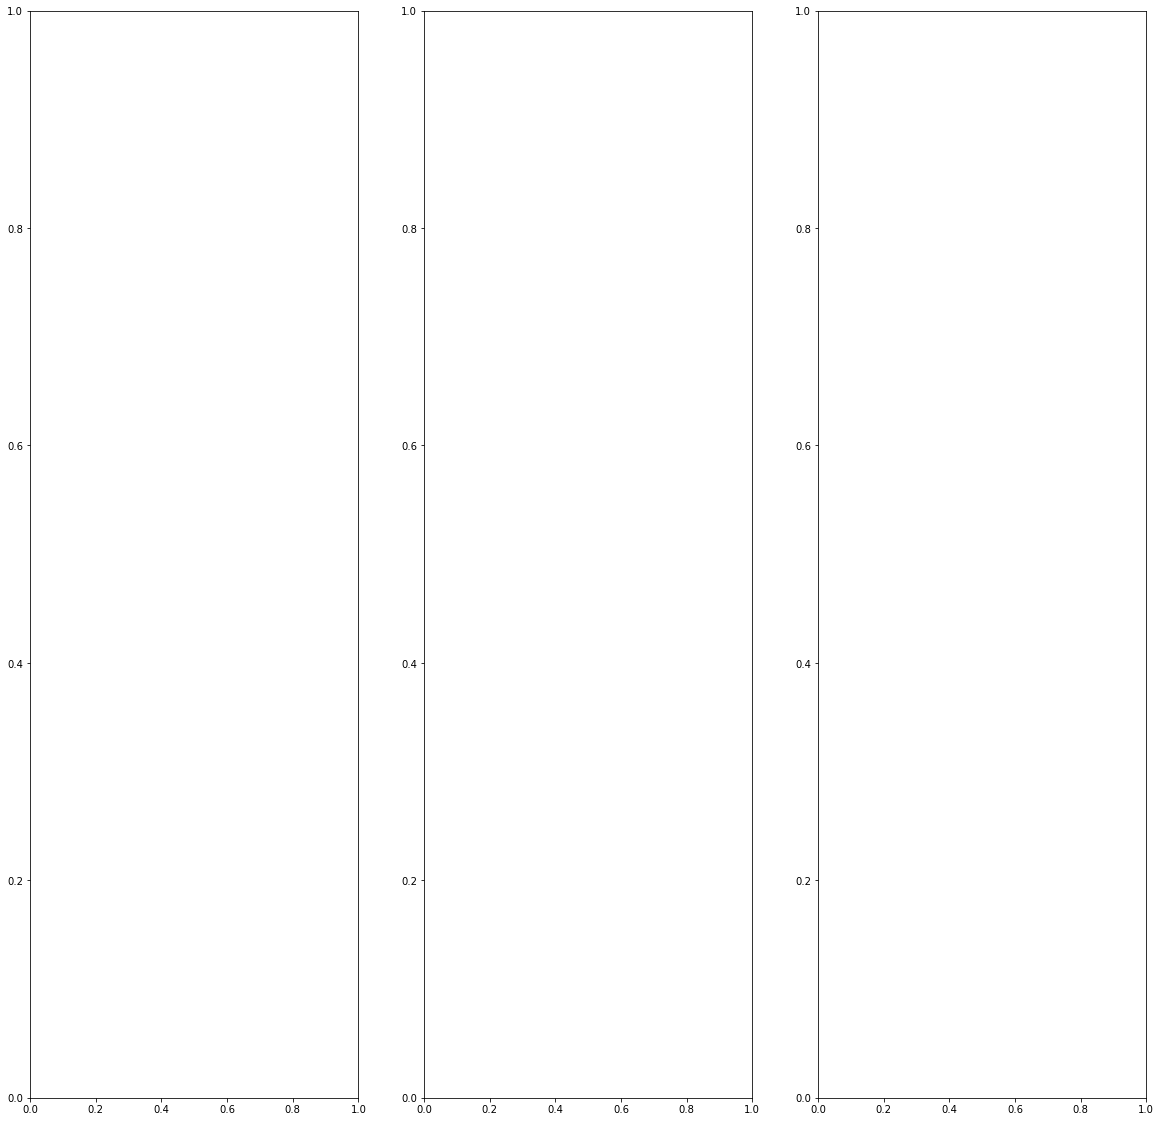

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
for i, model_tuple in zip(range(len(eval_models)), eval_models):
    for k in eval_k:
        model_name, model = model_tuple
        bol = (f1_res.k == k) & (f1_res.algorithm == model_name)
        ax[i].plot(f1_res[bol]["threshold"], f1_res[bol]["f1"], label=f"k: {k}")
    ax[i].set_title(model_name)
    ax[i].legend()
    ax[i].axis('square')
    ax[i].set_ylim(0.1, 0.5)
plt.show()

In [79]:
f1_res[f1_res.threshold == 0.99]

,k,threshold,f1,algorithm
99,10,0.99,NaN,1d
199,10,0.99,0.352941,2d
299,10,0.99,0.415094,deepfm
399,20,0.99,NaN,1d
499,20,0.99,0.319277,2d
599,20,0.99,0.341637,deepfm
699,30,0.99,NaN,1d
799,30,0.99,0.305164,2d
899,30,0.99,0.33244,deepfm


## 3. Feature importance

In [38]:
# TODO: feature importance for model in shapley

In [106]:
len(transactions["prod"].unique())

12304